# Emigration rates

At a high level:
- Use not-very-granular net international migration (NIM) estimates to work out emigration without many of the required stratifications.
- For the remaining stratifications, assume **emigrants** are like **immigrants.**

We do all operations at the **person** level, since that is the unit we have NIM estimates in.
Our final rate for household moves is therefore a *person-level* rate.
In the simulation, average household size will be the same for movers and non-movers within
a stratum, so this rate is the same as the *household-level* rate.

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
from numpy.random import default_rng
import scipy.stats as stats

pd.set_option('display.min_rows', 20)

! whoami
! date

zmbc
Tue 11 Apr 2023 01:45:18 PM PDT


In [2]:
acs = pd.read_hdf('../data/acs_2020_5yr_person.hdf', key='acs')

In [3]:
# Duplicate indices! In the future, should probably deal with this in download_acs!
# Filter to relevant columns to save memory
acs = acs[[
    'SERIALNO',
    'MIG',
    'RELSHIPP',
    'HISP',
    'RAC1P',
    'AGEP',
    'SEX',
    'NATIVITY',
    'ST',
    'PUMA',
    'PWGTP',
]].reset_index(drop=True)

In [4]:
len(acs[['ST', 'PUMA']].drop_duplicates())

2351

## Do subtraction of immigration - NIM to get total number of emigrants in each broad race group

NIM estimates are not fully stratified. They are available stratified only by county, and stratified only by (broad categories) of race/ethnicity.
We've decided to use the latter, since it will have more interesting PRL implications.

In [5]:
acs['immigrant'] = (acs.MIG == 2).astype(int)
acs['gq_person'] = acs.RELSHIPP.isin([37, 38]).astype(int)
acs['ref_person'] = (acs.RELSHIPP == 20).astype(int)
acs['immigrant_ref_person'] = ((acs.ref_person == 1) & (acs.immigrant == 1)).astype(int)

In [6]:
acs['hispanic'] = (acs.HISP != 1).astype(int)
acs['white_alone'] = (acs.RAC1P == 1).astype(int)
acs['three_category_race_eth'] = np.where(acs.hispanic == 1, 'hispanic', np.where(acs.white_alone == 1, 'white_alone_not_hispanic', 'other'))

In [7]:
# Data source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-detail.html
# Download from: https://www2.census.gov/programs-surveys/popest/tables/2010-2019/national/asrh/nc-est2019-compn.xlsx
# Values extracted for annual (1-year, same as the ACS immigration question) change: total, Hispanic, non-Hispanic White alone. The "other" category should = total - Hispanic - non-Hispanic White alone.
nim = pd.DataFrame([
    {'three_category_race_eth': 'hispanic', 'nim': 153_766},
    {'three_category_race_eth': 'white_alone_not_hispanic', 'nim': 64_469},
    {'three_category_race_eth': 'other', 'nim': 595_348 - 153_766 - 64_469},
])
nim

,three_category_race_eth,nim
0,hispanic,153766
1,white_alone_not_hispanic,64469
2,other,377113


In [8]:
immigration_by_race_eth = acs[acs.immigrant == 1].groupby('three_category_race_eth').PWGTP.sum().rename('immigration')

In [9]:
emigration_by_race_eth = immigration_by_race_eth.reset_index().merge(nim, on='three_category_race_eth').assign(emigration=lambda x: x.immigration - x.nim).set_index('three_category_race_eth')
emigration_by_race_eth

,immigration,nim,emigration
three_category_race_eth,,,
hispanic,467697,153766,313931
other,755459,377113,378346
white_alone_not_hispanic,619679,64469,555210


## Split that into a count by move type, according to the proportions of ACS immigrants in each category

In [10]:
acs['move_type'] = np.where(
    acs.immigrant == 1,
    np.where(
        acs.gq_person == 1,
        'gq person',
        np.where(
            acs.SERIALNO.isin(acs[acs.immigrant_ref_person == 1].SERIALNO),
            'household',
            'non-reference person',
        )
    ),
    'none'
)

In [11]:
type_proportions_by_race_eth = (acs[acs.immigrant == 1].groupby(['three_category_race_eth', 'move_type']).PWGTP.sum() / acs[acs.immigrant == 1].groupby(['three_category_race_eth']).PWGTP.sum())
emigration_by_race_eth_type = emigration_by_race_eth.emigration * type_proportions_by_race_eth
ratio_to_original = emigration_by_race_eth_type.groupby('three_category_race_eth').sum() / emigration_by_race_eth.emigration
assert (0.99 < ratio_to_original).all() and (ratio_to_original < 1.01).all()
emigration_by_race_eth_type

three_category_race_eth   move_type           
hispanic                  gq person                21645.067120
                          household               136509.512062
                          non-reference person    155776.420817
other                     gq person                28330.162892
                          household               187687.829974
                          non-reference person    162328.007135
white_alone_not_hispanic  gq person                32817.364926
                          household               351591.457142
                          non-reference person    170801.177932
dtype: float64

## Prepare to distribute counts by additional demographics

In order to do this, we need to add simulation demographics columns to ACS.

In [12]:
# Based on code from vivarium_census_prl_synth_pop repository:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L105-L118

LATINO_VAR_MAP = {i: (1 if i == 1 else 0) for i in range(1, 25)}

RACE_ETHNICITY_VAR_MAP = {
    0: "Latino",
    1: "White",
    2: "Black",
    3: "AIAN",
    4: "AIAN",
    5: "AIAN",
    6: "Asian",
    7: "NHOPI",
    8: "Multiracial or Other",
    9: "Multiracial or Other",
}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L99-L106

acs["race_ethnicity"] = acs.HISP.map(LATINO_VAR_MAP)
acs.loc[acs.race_ethnicity == 1, "race_ethnicity"] = acs.loc[
    acs.race_ethnicity == 1
].RAC1P

# label each race/eth
acs.race_ethnicity = acs.race_ethnicity.map(RACE_ETHNICITY_VAR_MAP)

In [13]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L120

SEX_VAR_MAP = {1: "Male", 2: "Female"}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L109

acs['sex'] = acs.SEX.map(SEX_VAR_MAP)

In [14]:
acs['born_in_us'] = acs.NATIVITY.map({1: 1, 2: 0})

In [15]:
acs['age_group'] = pd.cut(acs.AGEP, [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)

In [16]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/6b89c9243035592d595a142390b83dedb567896b/src/vivarium_census_prl_synth_pop/utilities.py#L196-L216
# with modifications
def vectorized_choice(
    options,
    n_to_choose: int,
    rng,
    weights = None,
    additional_key = None,
):
    if weights is None:
        n = len(options)
        weights = np.ones(n) / n
    # for each of n_to_choose, sample uniformly between 0 and 1
    probs = rng.random(n_to_choose)

    # build cdf based on weights
    pmf = weights / weights.sum()
    cdf = np.cumsum(pmf)

    # for each p_i in probs, count how many elements of cdf for which p_i >= cdf_i
    # slow way
    # vect_find_index = np.vectorize(lambda p_i: (p_i >= cdf).sum())
    # chosen_indices = vect_find_index(probs)
    # fast way
    chosen_indices = np.searchsorted(cdf, probs, side='right')
    return np.take(options, chosen_indices)

## Logic for distributing counts

In [17]:
from vehss.model import distribute_values

In [18]:
def perturb_with_unconditional(df, acs_subset, acs_full, rng, columns, subset_prob=0.4, all_prob=0.1):
    perturb_propensity = pd.Series(rng.random(len(df)), index=df.index)
    subset_cutoff = (1 - all_prob - subset_prob)
    assert subset_cutoff >= 0
    all_cutoff = (1 - all_prob)

    subset_perturb_indices = df.index[(perturb_propensity > subset_cutoff) & (perturb_propensity <= all_cutoff)]
    donors_subset = acs_subset.loc[vectorized_choice(acs_subset.index, len(subset_perturb_indices), rng, weights=acs_subset.PWGTP), columns]
    donors_subset.index = subset_perturb_indices
    
    all_perturb_indices = df.index[perturb_propensity > all_cutoff]
    donors_all = acs_full.loc[vectorized_choice(acs_full.index, len(all_perturb_indices), rng, weights=acs_full.PWGTP), columns]
    donors_all.index = all_perturb_indices

    df.loc[subset_perturb_indices, columns] = donors_subset[columns]
    df.loc[all_perturb_indices, columns] = donors_all[columns]
    return df

In [19]:
def sample_with_perturbation(acs_df, full_acs, rng, n, perturb_col_suffix=''):
    # NOTE: Unlike in the simulation, we only ever sample with the sampling unit being a person.
    sample = acs_df.loc[vectorized_choice(acs_df.index, n, rng, weights=acs_df.PWGTP)].reset_index(drop=True)

    sample = perturb_with_unconditional(sample, acs_df, full_acs, rng, ['ST' + perturb_col_suffix, 'PUMA' + perturb_col_suffix])
    # We don't perturb race because it is unclear how to do this at the household level.
    # sample = perturb_with_unconditional(sample, acs_df, full_acs, rng, ['three_category_race_eth' + perturb_col_suffix, 'race_ethnicity' + perturb_col_suffix], subset_prob=0.2, all_prob=0.1)

    age_col = 'AGEP' + perturb_col_suffix
    lower_bound = np.where((sample.gq_person == 1) & (sample[age_col] >= 18), -1 * (sample[age_col] - 18), -1 * sample[age_col])
    mean = 0
    std = 10
    age_shift = stats.truncnorm(a=((lower_bound - mean) / std), b=np.inf, loc=mean, scale=std).rvs(random_state=rng)

    sample[age_col] += age_shift
    sample[age_col] = np.clip(sample[age_col], -np.inf, 99.9999)
    
    sample['age_group' + perturb_col_suffix] = pd.cut(sample[age_col], [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)
    
    return sample

In [20]:
def sample_acs_move_type(acs_df, move_type, rng_seed=12345, n=350_000_000, perturb_col_suffix=''):
    acs_subset = acs_df[(acs_df.immigrant == 1) & (acs_df.move_type == move_type)]
    return sample_with_perturbation(acs_subset, acs_df, default_rng(rng_seed), n=n, perturb_col_suffix=perturb_col_suffix)

In [21]:
def get_at_risk_pop(acs_df, move_type):
    at_risk = acs_df[(acs_df.gq_person == (move_type == 'gq person'))]
    if move_type == 'non-reference person':
        at_risk = at_risk[at_risk.ref_person == 0]
    return at_risk

In [22]:
def sample_acs_at_risk(acs_df, move_type, rng_seed=12345, n=350_000_000, perturb_col_suffix=''):
    at_risk = get_at_risk_pop(acs_df, move_type)
    return sample_with_perturbation(at_risk, acs_df, default_rng(rng_seed), n=n, perturb_col_suffix=perturb_col_suffix)

In [23]:
def distribute_by_immigration_and_calculate_rate(emigration, distribute_by, acs_df, move_type, at_risk, stratification_columns=['age_group', 'sex', 'race_ethnicity', 'born_in_us'], col_suffix=''):
    # TODO: We should be able to drop "move_type" here instead of after distribute_values,
    # but distribute_values has a bug that makes it not work when there is only one level to the index.
    emigration_to_distribute = emigration[emigration.index.get_level_values('move_type') == move_type]

    distribution_values = distribute_by.groupby(['three_category_race_eth'] + [c + col_suffix for c in stratification_columns]).size()
    emigration_stratified_count, _ = distribute_values(
        pd.DataFrame(emigration_to_distribute.rename('emigration')),
        pd.DataFrame(distribution_values.rename('emigration')),
        '+',
        full_match=False,
        zero_weight_equal=False,
    )
    emigration_stratified_count = emigration_stratified_count['emigration'].droplevel('move_type')

    if 'race_ethnicity' in stratification_columns and col_suffix == '':
        # three_category_race_eth in the result is redundant to race_ethnicity.
        # distribute_values doesn't yet support a hierarchical relationship (three_category_race_eth -> race_ethnicity) so it returns all combinations.
        # We get rid of all the combinations that don't make sense, which should have zero values anyway, then remove three_category_race_eth.
        possible_combos = acs_df[['three_category_race_eth', 'race_ethnicity']].drop_duplicates()
        race_eth_to_category_mapping = possible_combos.set_index('race_ethnicity').three_category_race_eth
        assert race_eth_to_category_mapping.index.is_unique

        race_eth_values = emigration_stratified_count.index.get_level_values('race_ethnicity')
        race_eth_category_values = emigration_stratified_count.index.get_level_values('three_category_race_eth')
        total_count = emigration_stratified_count.sum()
        emigration_stratified_count = emigration_stratified_count[race_eth_values.map(race_eth_to_category_mapping) == race_eth_category_values].droplevel('three_category_race_eth')
        assert np.isclose(emigration_stratified_count.sum(), total_count)
    elif col_suffix == '_ref_person':
        # In this case, three_category_race_eth is not redundant and can't be simply eliminated.
        # However, we never want to use it in the sim when we will be sampling reference people/household units,
        # as there is no way to do this sampling while matching the three_category_race_eth of the
        # emigrants themselves (not their reference people).
        # So, we throw away the three_category_race_eth information by aggregation.
        emigration_stratified_count = emigration_stratified_count.groupby([c + col_suffix for c in stratification_columns]).sum()

    total_denominator = get_at_risk_pop(acs_df, move_type).PWGTP.sum()
    denominators = (
        total_denominator *
        (at_risk.groupby(emigration_stratified_count.index.names).size() / len(at_risk))
    )
    assert 0.99 < denominators.sum() / total_denominator < 1.01

    return emigration_stratified_count, (emigration_stratified_count / denominators).rename('emigration_rate')

## Non-reference-person emigration rate

- With the count of non-reference-person emigrants:
  - Distribute that count of non-reference-person emigrants using age/sex/race/birthplace/PUMA? proportions among non-reference-person immigrants in ACS.
  - Divide each sub-count by the people in that age/sex/race/birthplace/PUMA? group in ACS to get the rate.
  - Sample individuals for emigration at that rate.

In [24]:
def display_sample_size(acs_df, move_type, stratification_columns=['age_group', 'sex', 'race_ethnicity', 'born_in_us'], col_suffix=''):
    acs_subset = acs_df[(acs_df.immigrant == 1) & (acs_df.move_type == move_type)]
    sample_size = acs_subset.groupby([col + col_suffix for col in stratification_columns]).size().rename('sample_size').reset_index()
    sample_size[['age_start', 'age_end']] = [[x.left, x.right] for x in sample_size['age_group' + col_suffix]]
    sample_size['age'] = np.average(sample_size[['age_start', 'age_end']], axis=1)

    g = sns.relplot(
        data=sample_size,
        x="age", y="sample_size",
        hue="race_ethnicity" + col_suffix,
        row="born_in_us" + col_suffix, col="sex" + col_suffix,
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )
    g.set(yscale="symlog")
    g.set(ylim=(0, None))
    return g

In [25]:
def display_emigration_rates(emigration_rates, name):
    emigration_rates = emigration_rates.rename(name).reset_index()
    emigration_rates[['age_start', 'age_end']] = [[x.left, x.right] for x in emigration_rates['age_group']]
    emigration_rates['age'] = np.average(emigration_rates[['age_start', 'age_end']], axis=1)
    
    sns.relplot(
        data=emigration_rates,
        x="age", y=name,
        hue="race_ethnicity",
        row="born_in_us", col="sex",
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )

In [26]:
def format_emigration_rates_for_file(emigration_rates, name):
    emigration_rates = emigration_rates.rename(name).reset_index()
    age_bound_cols = ['age_start', 'age_end']
    emigration_rates[age_bound_cols] = [[x.left, x.right] for x in emigration_rates['age_group']]
    emigration_rates = emigration_rates.drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})
    return emigration_rates[age_bound_cols + [c for c in emigration_rates.columns if c not in age_bound_cols]]

## GQ person emigration rate

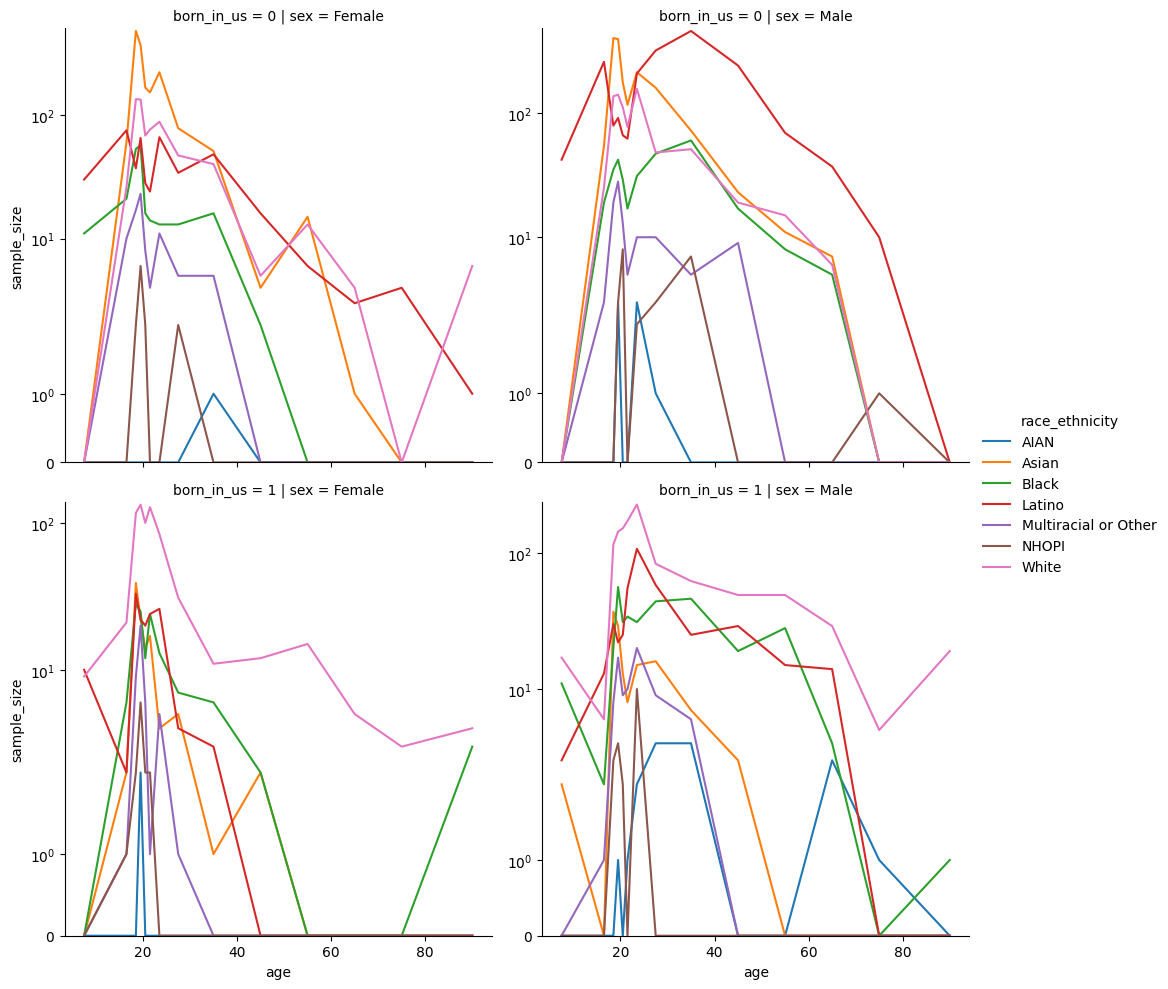

In [27]:
display_sample_size(acs, 'gq person')

In [28]:
%%time

distribute_by = sample_acs_move_type(acs, 'gq person')

CPU times: user 8h 44min 33s, sys: 34min 34s, total: 9h 19min 8s
Wall time: 8h 45min 36s


In [29]:
%%time

at_risk = sample_acs_at_risk(acs, 'gq person')

CPU times: user 8h 32min 5s, sys: 32min 34s, total: 9h 4min 39s
Wall time: 8h 35min 40s


In [30]:
%%time

gq_emigration_counts, gq_emigration_rates = distribute_by_immigration_and_calculate_rate(emigration_by_race_eth_type, distribute_by, acs, 'gq person', at_risk)

Starting from values at the three_category_race_eth/move_type level
Applying proportions at the three_category_race_eth/age_group/sex/race_ethnicity/born_in_us level
Generating values at the three_category_race_eth/move_type/age_group/sex/race_ethnicity/born_in_us level
Linking on three_category_race_eth
CPU times: user 2min 29s, sys: 49.3 s, total: 3min 18s
Wall time: 3min 17s


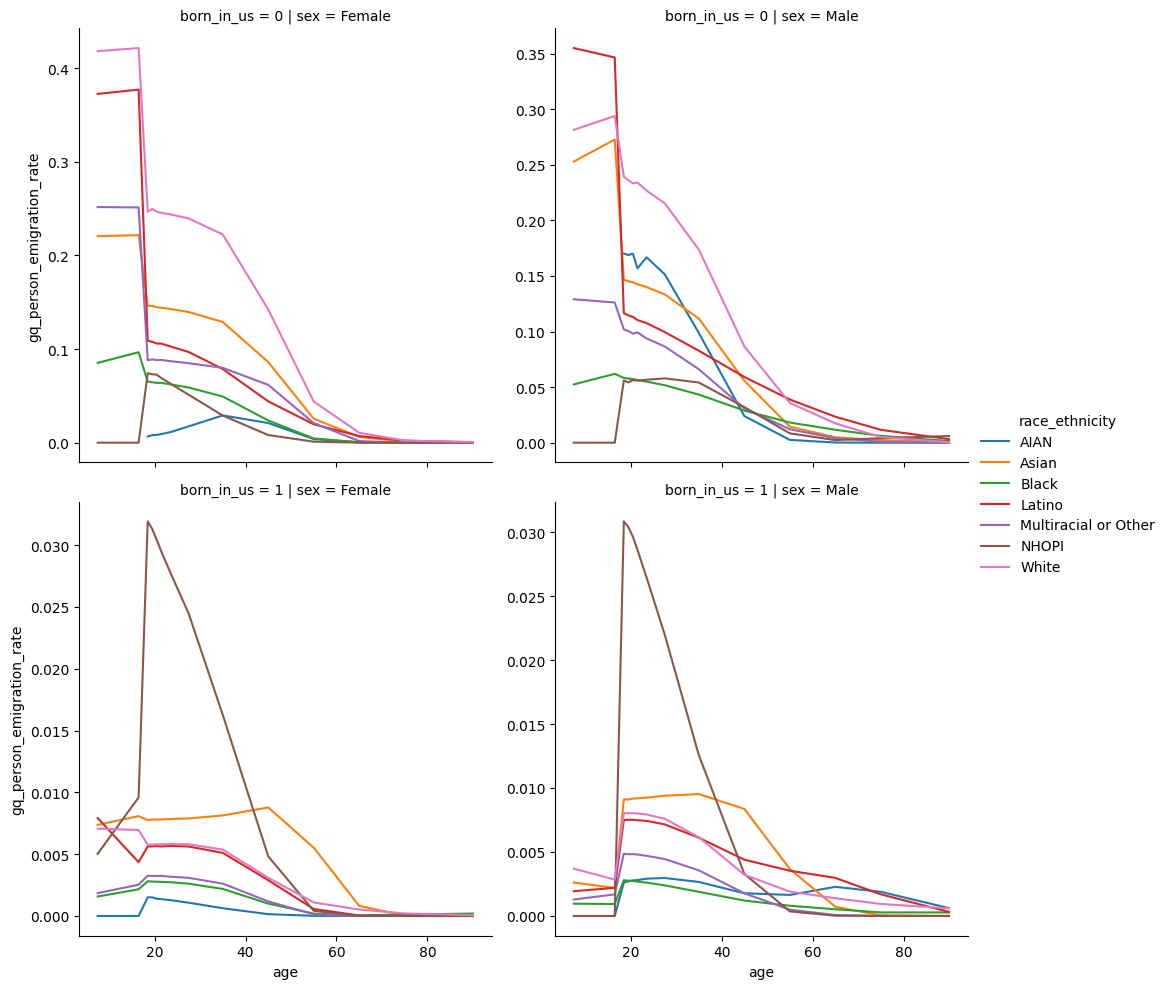

In [31]:
display_emigration_rates(gq_emigration_rates, 'gq_person_emigration_rate')

In [32]:
%%time

gq_emigration_counts_by_state, gq_emigration_rates_by_state = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs,
    'gq person',
    at_risk,
    stratification_columns=['age_group', 'sex', 'race_ethnicity', 'born_in_us', 'ST']
)

Starting from values at the three_category_race_eth/move_type level
Applying proportions at the three_category_race_eth/age_group/sex/race_ethnicity/born_in_us/ST level
Generating values at the three_category_race_eth/move_type/age_group/sex/race_ethnicity/born_in_us/ST level
Linking on three_category_race_eth
CPU times: user 2min 43s, sys: 55.4 s, total: 3min 38s
Wall time: 3min 37s


In [33]:
gq_emigration_rates_by_state

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1          NaN
                                               2          NaN
                                               4          NaN
                                               5          NaN
                                               6          NaN
                                               8          NaN
                                               9          NaN
                                               10         NaN
                                               11         NaN
                                               12         NaN
                                                       ...   
[80, 100)  Male    White           1           46    0.000083
                                               47    0.000229
                                               48    0.000650
                                               49    0.001072
                    

In [34]:
gq_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            1           1     0.0
[70, 80)   Female  NHOPI           0           45    0.0
                                               44    0.0
                                               42    0.0
                                               41    0.0
                                               40    0.0
                                               39    0.0
                                               46    0.0
                                               38    0.0
                                               36    0.0
                                                    ... 
[80, 100)  Male    AIAN            0           30    NaN
                                               35    NaN
                                               38    NaN
                                               40    NaN
                                               41    NaN
                                      

In [35]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state.isnull()])

265

In [36]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state == np.inf])

51

In [37]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state == 0])

1939

In [38]:
gq_emigration_rates_by_state = gq_emigration_rates_by_state.replace(np.inf, np.nan).fillna(gq_emigration_rates_by_state.median())
gq_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity        born_in_us  ST
[80, 100)  Female  Black                 0           56    0.000000
                   Multiracial or Other  0           45    0.000000
                                                     44    0.000000
                                                     42    0.000000
                                                     41    0.000000
                                                     40    0.000000
                                                     39    0.000000
                                                     38    0.000000
                                                     37    0.000000
                                                     36    0.000000
                                                             ...   
[21, 22)   Male    AIAN                  0           35    1.027201
[15, 18)   Female  White                 0           35    1.065554
[0, 15)    Female  Multiracial or Other  0           38    1

In [39]:
format_emigration_rates_for_file(gq_emigration_rates_by_state, 'gq_person_emigration_rate').to_csv('sim_inputs/group_quarters_person_emigration_rates.csv', index=False)